# Building a Deep Feedforward Neural Network

In this chapter, we will cover the following recipes:

* Training a vanilla neural network
* Scaling the input dataset
* Impact of training when the majority of inputs are greater than zero
* Impact of batch size on model accuracy
* Building a deep neural network to improve network accuracy
* Varying the learning rate to improve network accuracy
* Varying the loss optimizer to improve network accuracy
* Understanding the scenario of overfitting
* Speeding up the training process using batch normalization

## Training a Vanilla neural network

To understand how to train a vanilla neural network, we will go through the task of predicting the label of a digit in the MNIST dataset, which is a popular dataset of images of digits (one digit per image) and the corresponding label of the digit that is contained in the image. 

### Getting ready

Training a neural network is done in the following steps:

1. Import the relevalnt package and datasets
2. Preprocess the targets(convert them into one-hot encoded verctors) so that we can perform optimization on top of them:
   1. We shall be minimizing **categorical cross entropy loss**
3. Create train and test datasets:
   1. We have the train dataset so that we create a model based on it
   2. The test dataset is not seen by the model
      1. Hence, the accuracy on the test dataset is an indicator of how well the model is likely to work on data when the model is productionalized, as data in the production scenario (which might occur a few days/weeks after building the model) cannot be seen by the model
4. Initialize a model
5. Define the model architecture:
   1. Specify the number of units in a hidden layer
   2. Specify the activation function that is to be performed in a hidden layer
   3. Specify the number of hidden layers
   4. Specify the loss function that we want to minimize
   5. Provide the optimizer that will minimize the loss function
6. Fit the model:
   1. Mention the batch size to update weights
   2. Mention the total number of epochs
7. Test the model
   1. Mention the validation data, otherwise, mention the validation split, which will consider the last x% of total data as test data
   2. Calculate the accuracy and loss values on top of the test dataset
8. Check for anything interesting in the way in which loss value and accuracy values changed over an increasing number of epochs

Using this strategy, let's go ahead and build a neural network model in Keras, in the following section.

### How to do it

In [1]:
# 1. Import the relevant packages and dataset,
# and visualize the input dataset
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 28s 2us/step


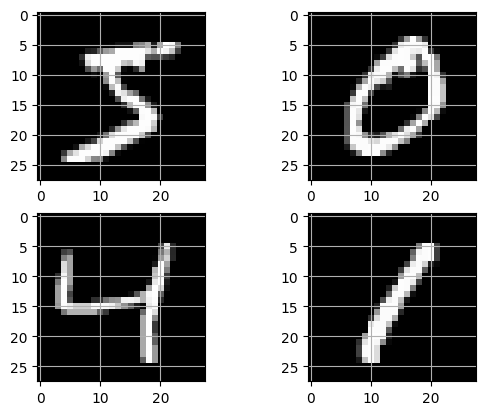

In [2]:
# 2 The MNIST dataset contains images of digits where the images
# are 28 x 28 in shape. Let's plot a few images to see what they
# will look like
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.grid('off')
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.grid('off')
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.grid('off')
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
plt.grid('off')
plt.show()

In [5]:
# 3 Flatten the 28 X 28 images so that the inpyt is all the 784 pixel values
# additionnaly, one hot encode the outputs. This step is key in the dataset
# prep process
# flatten 28 X 28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In the preceding step, we are reshaping the input dataset using the reshape method that converts an array of a given shape into a different shape. In this specific case, we are converting an array that has an `X_train.shape[0]` number of data points (images) where there are `X_train.shape[1]` rows and `X_train.shape[2]` columns in each image, into an array of an `X_train.shape[0]` number of data points (images) and `X_train.shape[1] * X_train.shape[2]` values per image. Similarly, we perform the same exercise on the test dataset

In [6]:
# One hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Let's try to understand how one-hot encoding works. If the unique possible labels are ${0, 1, 2, 3}$, they will be one-hot encoded, as follows:

| Label | 0   | 1   | 2   | 3   |
| ----- | --- | --- | --- | --- |
| 0     | 1   | 0   | 0   | 0   |
| 1     | 0   | 1   | 0   | 0   |
| 2     | 0   | 0   | 1   | 0   |
| 3     | 0   | 0   | 0   | 1   |

Essentially, each label will occupy a unique column in the dataset, and if the label is present, the column value will be one, and every other column value will be zero.

In Keras, the one-hot encoding approach on top of labels is performed using the `to_categorical` method, which figures out the number of unique labels in the target data, and then converts them into a one-hot encoded vector.

In [7]:
# 4 Build a neural network with a hidden layer with 1,000 units
model = Sequential()
model.add(Dense(1000, input_dim = 784, activation='relu'))
model.add(Dense(10, activation='softmax'))

In the preceding step, we mention that the input has $784$ values that are connected to $1,000$ values in a hidden layer. Additionally, we are also specifying that **the activation, which is to be performed in the hidden layer after the matrix multiplication of the input and the weights** connecting the input and hidden layer, is the ReLu activation.

Finally, the hidden layer is connected to an output that has $10$ values (as there are $10$ columns in the vector created by the `to_categorical` method), and we perform `softmax` on top of the output so that we **obtain the probability of an image belonging to a certain class**.

In [8]:
# 5 The preceding model architecture can be visualized as follows
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              785000    
                                                                 
 dense_1 (Dense)             (None, 10)                10010     
                                                                 
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________


In the preceding architecture, the number of parameters in the first layer is $785,000$, as the $784$ input units are connected to $1,000$ hidden units, resulting in $784 \times 1,000$ weight values, and $1,000$ bias values, for the $1,000$ hidden units, resulting in a total of $785,000$ parameters.

Similarly, the output layer has $10$ outputs, which are connected to each of the $1,000$ hidden layers, resulting in $1,000 \times 10$ parameters and $10$ biases—a total of $10,010$ parameters.

The output layer has $10$ units as there are $10$ possible labels in the output. **The output layer now gives us a probability value for each class for a given input image**.

In [9]:
# 6 Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Note that **because the target variable is a one-hot encoded vector with multiple classes in it, the loss function will be a categorical cross-entropy loss**.

Additionally, we are using the **Adam optimizer** to **minimize the cost function** (more on different optimizers in the *Varying the loss optimizer to improve network accuracy recipe*).
We are also noting that we will need to look at the accuracy metric while the model is getting trained.

In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
# 7 Fit the model as follows
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32, verbose=1)

Epoch 1/500
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1995 - accuracy: 0.9650 - val_loss: 0.5365 - val_accuracy: 0.9538
Epoch 2/500
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2126 - accuracy: 0.9653 - val_loss: 0.4033 - val_accuracy: 0.9545
Epoch 3/500
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2031 - accuracy: 0.9661 - val_loss: 0.4141 - val_accuracy: 0.9548
Epoch 4/500
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1960 - accuracy: 0.9675 - val_loss: 0.4735 - val_accuracy: 0.9565
Epoch 5/500
1875/1875 [==============================] - 8s 5ms/step - loss: 0.1690 - accuracy: 0.9699 - val_loss: 0.4762 - val_accuracy: 0.9589
Epoch 6/500
1875/1875 [==============================] - 8s 5ms/step - loss: 0.1794 - accuracy: 0.9697 - val_loss: 0.5248 - val_accuracy: 0.9553
Epoch 7/500
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1737 - accuracy: 0.9709 - val_loss: 0.5362 - val_ac

In the preceding code, we have specified the input (`X_train`) and the output (`y_train`) that the model will fit. Additionally, we also specify the input and output of the test dataset, which the model will not use to train weights; however it, will give us an idea of how different the loss value and accuracy values are between the training and the test datasets.


In [16]:
# 8 Extract the training and test loss and accuracy metrics over different epochs
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)

While fitting a model, the history variable will have stored the accuracy and loss values corresponding to the model in each epoch for both the training and the test datasets. In the preceding steps, we are storing those values in a list so that we can plot the variation of accuracy and loss in both the training and test datasets over an increasing number of epochs.

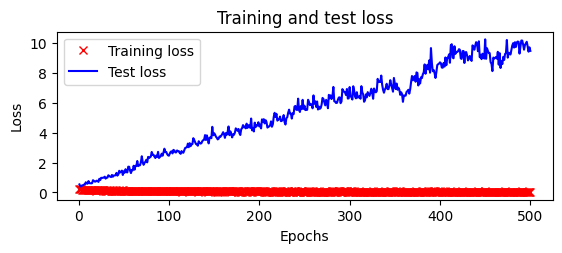

C:\Users\ibrao\AppData\Local\Temp\ipykernel_21560\2597169296.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


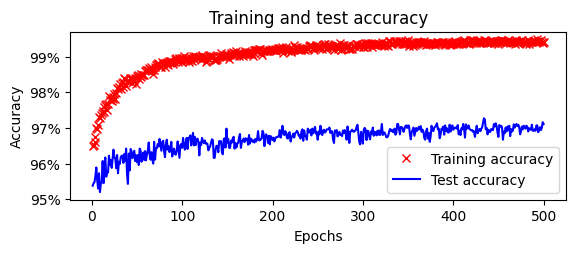

In [18]:
# 9 Visualize the training and test loss and the accuracy over a different number of epochs
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'rx', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['accuracy'], 'rx', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.show()

The preceding code produces the following diagram, where the first plot shows the training and test loss values over increasing epochs, and the second plot shows the training and test accuracy over increasing epochs:

Note that the previous network resulted in an accuracy of $97\%$. Also, note that loss values (and thereby, accuracy) have a step change over a different number of epochs. We will contrast this change in loss with the scenario when the input dataset is scaled in the next section.

In [19]:
# 10 Let's calculate the accuracy of the model manually:
preds = model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


In the preceding step, we are using the predict method to calculate the expected output values for a given input (`X_test` in this case) to the model. Note that we are specifying it as `model.predict`, as we have initialized a sequential model named `model`:

In [20]:
import numpy as np
correct = 0
for i in range(len(X_test)):
    pred = np.argmax(preds[i],axis=0)
    act = np.argmax(y_test[i],axis=0)
    if(pred==act):
        correct+=1
    else:
        continue

correct/len(X_test)

0.9711

In the preceding code, we are looping all of the test predictions one at a time. For each test prediction, we are perming `argmax` to obtain the index that has the highest probability value.

Similarly, we perform the same exercise for the actual values of the test dataset. The prediction of the index of the highest value is the same in both the prediction and the actual values of the test dataset.
Finally, the number of correct predictions over the total number of data points in the test dataset is the accuracy of the model on the test dataset.

### How it works

The key steps that we have performed in the preceding code are as follows:

* We flattened the input dataset so that **each pixel is considered a variable** using the `reshape` method
* We **performed one-hot encoding on the output values** so that we can distinguish between different labels using the `to_categorical` method in the `np_utils` package
* We built a **neural network with a hidden layer using the sequential addition of layers**
* We compiled the neural network to **minimize the categorical cross entropy loss** (as **the output has 10 different categories)** using the `model.compile` method
* We fitted the model with training data using the `model.fit` method
* We extracted the **training and test loss accuracies across all the epochs that were stored in the history**
* We predicted the probability of each class in the test dataset using the `model.predict` method
* We looped through all the images in the test dataset and **identified the class that has the highest probability**
* Finally, we calculated the accuracy (**the number of instances in which a predicted class matches the actual class of the image out of the total number of instances**)

## Scaling the input dataset
Scaling a dataset is a process where we limit the variables whithin a dataset to ensure they do not have a very wide range of different values. One way to achieve this is to **divide each variable in the dataset by the maximum value of the variable**. Typically, neural nets perform well when we scale the input dataset.
Let's understand the reason neural networks perform better when the dataset is scaled.

### Getting ready

To understand the impact of the scaling input on the output, let's contrast the scenario where we check the output when the input dataset is not scaled, with the output when the input dataset is scaled.

Input data is not scaled\
![](input_not_scaled.png)

In the preceding table, note that the output (sigmoid) did not vary a lot, even though the weight value varied from $0.01$ to $0.9$. The sigmoid function is calculated as the sigmoid value of the multiplication of the input with the weight, and then adding a bias to it:

```python
output = 1/(1+np.exp(-(w*x + b)))
```

Where `w` is the weight, `x` is the input, and b is the bias value.

The reason for no change in the sigmoid output is due to the fact that the multiplication of  `w*x` is a large number (as `x` is a large number) resulting in the sigmoid value always falling in the saturated portion of the sigmoid curve (saturated value on the top-right or bottom-left of the sigmoid curve).

In this scenario, let's multiply different weight values by a small input number, as follows

![](input_scaled.png)

The sigmoid output in the preceding table varies, as the input and weight values are small, resulting in a smaller value when the input and the weight are multiplied, further resulting in the sigmoid value having variation in output.

From this exercise, we learned about the importance of scaling the input dataset so that it results in a smaller value when the weights (provided the weights do not have a high range) are multiplied by the input values. This phenomenon results in the weight value not getting updated quickly enough.

Thus, to achieve the optimal weight value, we should scale our input dataset while initializing the weights to not have a huge range (typically, weights have a random value between $-1$ and $+1$ during initialization).

These issues hold true when the weight value is also a very big number. Hence, we are better off initializing the weight values as a small value that is closer to zero.

### How to do it

Let's go through the set up of scaling the dataset that we have used in the previous section, and compare the results with and without scaling:

In [2]:
# 1 Import the relevant packages and datasets
from keras.datasets import mnist
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 2 There are multiple ways to scale a dataset. One way is to convert all the data points
# to a value between zero and one (by dividing each data point with the maximum value in
# the total dataset, which is what we are doing in the following code). Another popular
# method, among the multiple other ways, is to normalize the dataset so that the values
# are between -1 and +1 by subtracting each data point with the overall dataset mean, and
# then dividing each resulting data point by the standard deviation of values in the original dataset

# Now we will be flattening the input dataset and scaling it
# flatten 28 X 28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

X_train = X_train/255
X_test = X_test/255

In the preceding step, we **have scaled the training and test inputs to a value between zero and one by dividing each value by the maximum possible value in the dataset**, which is $255$. Additionally, we convert the output dataset into a one-hot encoded format

In [4]:
# One hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[0]

# 3 Build the model and compile it using the following code
model = Sequential()
model.add(Dense(1000, input_dim=784, activation='relu'))
model.add(Dense(10, input_dim=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Note that the preceding model is exactly the same as the one we built in the previous section. However, the only difference is that it will be executed on the training dataset that is scaled, whereas the previous one was not scaled.

In [5]:
# 4 Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1875/1875 [==============================] - 22s 10ms/step - loss: 0.1848 - accuracy: 0.9448 - val_loss: 0.0928 - val_accuracy: 0.9709
Epoch 2/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0746 - accuracy: 0.9776 - val_loss: 0.0824 - val_accuracy: 0.9745
Epoch 3/50
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0487 - accuracy: 0.9841 - val_loss: 0.0754 - val_accuracy: 0.9773
Epoch 4/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0346 - accuracy: 0.9890 - val_loss: 0.0686 - val_accuracy: 0.9805
Epoch 5/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0264 - accuracy: 0.9917 - val_loss: 0.0680 - val_accuracy: 0.9807
Epoch 6/50
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.0733 - val_accuracy: 0.9808
Epoch 7/50
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0174 - accuracy: 0.9941 - val_loss: 0.0772 - va

In [8]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)

You will notice that the accuracy of the preceding model is $\pm 98.25\%$.

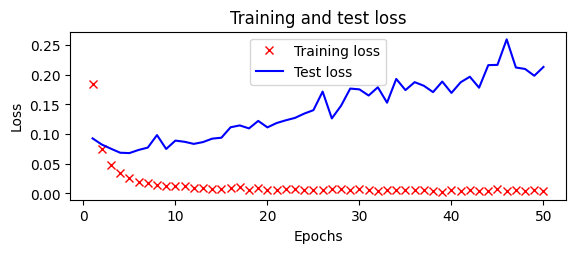

C:\Users\ibrao\AppData\Local\Temp\ipykernel_10712\1301501705.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


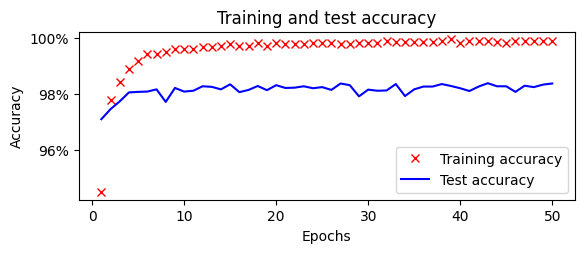

In [9]:
# Plot the training and test accuracy and the loss values over different
# epochs (the code to generate the following plots remains the same as the
# one we used in step 8 of the Training a vanilla neural network recipe):
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'rx', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['accuracy'], 'rx', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.show()

In [10]:
import numpy as np

preds = model.predict(X_test)
correct = 0
for i in range(len(X_test)):
    pred = np.argmax(preds[i],axis=0)
    act = np.argmax(y_test[i],axis=0)
    if(pred==act):
        correct+=1
    else:
        continue

correct/len(X_test)

313/313 [==============================] - 2s 5ms/step


0.9837

From the preceding diagram, you should notice that training and test losses decreased smoothly over increasing epochs when compared to the non-scaled dataset that we saw in the previous section.

While the preceding network gave us good results in terms of a smoothly decreasing loss value, we **noticed that there is a gap between the training and test accuracy/loss values, indicating that there is potential overfitting on top of the training dataset**. **Overfitting** is the phenomenon where the model specializes on the training data that it might not work as well on the test dataset.

### How it works

The key steps that we have performed in the preceding code are as follows:
* We flattened the input dataset so that each pixel is considered a variable using `reshape` method
* Additionally, we scaled the dataset so that each variable now has a value between $0$ and $1$
  * We achieved the preceding by **dividing the values of a variable with the maximum value of that variable**
* We performed one-hot enciding on the output values so that we can distinguish between different labels using the `to_categorical` method in the np_utils package.
* We built a neural network with a hidden layer using the sequential addition of layers
* We compiled the neural network to minimize categorical cross entropy loss (as the output has 10 different categories) using the model.compile method
* We fitted the model with training data using the `model.fit` method
* We extracted the training and test losses accuracies across all the epochs that were stored in the history
* We also identified a scenario that we consider overfitting

### There's more

In addition to scaling a variable's values by dividing the values by the maximum among the values in a variable, the other commonly used scaling methods are as follows:

* Min-max normalization
* Mean normalization
* Standardization
More information about these scaling methods can be found on Wikipedia here: https://en.wikipedia.org/wiki/Feature_scaling.

## Impact on training when the majority of inputs are greater than $0$

So far, in the dataset that we have considered, we have not looked at the distribution of values in the input dataset. Certain values of the input result in faster training. In this section, we will understand a scenario where weights are trained faster when the training time depends on the input values.

### Getting ready

In this section, we will follow the model building process in exactly the same way as we did previously.

However, we will adopt a small change to our strategry:
* We will invert the background color, and also the foreground color. Essentially, the background will be colored white in this scenario, and the label will be written in blakc.

the intuition for this change impacting the model accuracy is as follows.

The pixels in the corner of images do not contribute toward predicting the label of an image. Given that a black pixel(original scenario) has a pixel value of $0$, it is automatically taken care of, as when this input is multiplied by any weight value, the output is $0$. This will result in the network learning that any change in the weight value connecting this corner pixel to a hidden layer will not have an impact on changing the loss value.

However, if we have a white pixel in the corner (where we already know that the corner pixels do not contribute toward predicting the label of an image), it will contribute toward certain hidden unit values, and thus the weights need to be fine-tuned until the impact of the corner pixels on the predicted label is minimal.

### How to do it

In [13]:
# 1 Load and scale the input dataset

(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

X_train = X_train/255
X_test = X_test/255
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# 2 Let's look at the distribution of the input values
X_train.flatten()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

The preceding code **flattens all the inputs into a single list**, and hence, is of the shape $(47,040,000)$, which is the same as the `28 x 28 x X_train.shape[0]`. Let's plot the distribution of all the input values:

Text(0, 0.5, 'Frequency of input values')

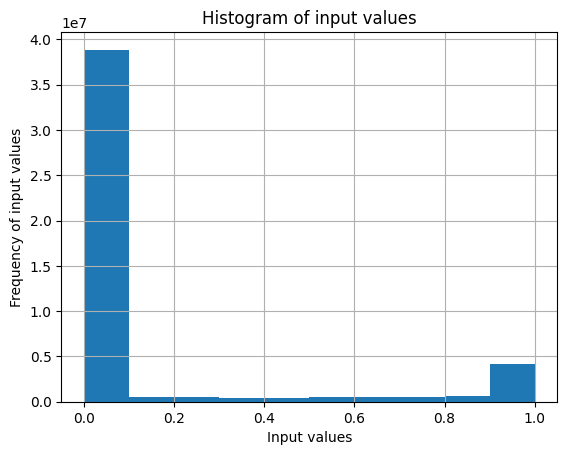

In [14]:
plt.hist(X_train.flatten())
plt.grid('off')
plt.title('Histogram of input values')
plt.xlabel('Input values')
plt.ylabel('Frequency of input values')

We notice that the majority of the inputs are $0$ (you should note all the input images have a background that is black hence, a majority of the values are $0$, which is the pixel value of the color black)

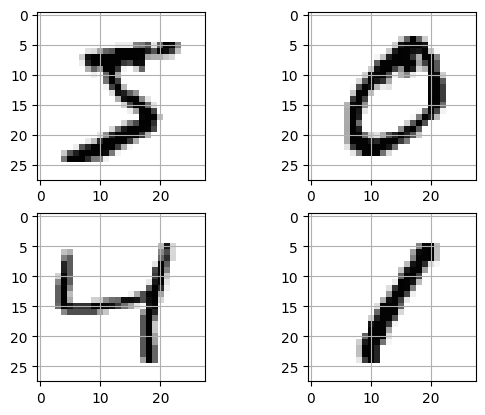

In [15]:
# 3 Let's explore a scenario where we invert the colors, in which the background is 
# white and the letters are written in black, using
X_train = 1-X_train
X_test = 1-X_test
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(221)
plt.imshow(X_train[0].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.grid('off')
plt.subplot(222)
plt.imshow(X_train[1].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.grid('off')
plt.subplot(223)
plt.imshow(X_train[2].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.grid('off')
plt.subplot(224)
plt.imshow(X_train[3].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.grid('off')
plt.show()

Text(0, 0.5, 'Frequency of input values')

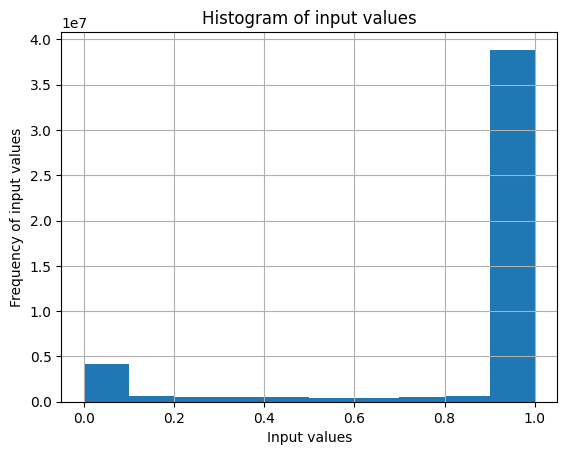

In [16]:
# The histogram of the resulting images now looks as follows
plt.hist(X_train.flatten())
plt.grid('off')
plt.title('Histogram of input values')
plt.xlabel('Input values')
plt.ylabel('Frequency of input values')

You should notice that the majority of the input values now have a value of one.

In [17]:
# 4 Let's go ahead and build our model using the same
# model architecture that we built in the
# Scaling input dataset section
model = Sequential()
model.add(Dense(1000,input_dim=784,activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)

# 5 Plot the training and test accuracy and loss
# values over different epochs (the code to generate
# the following plots remains the same as the one
# we used in step 8 of the Training a vanilla neural
# network recipe)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4845 - accuracy: 0.8546 - val_loss: 0.3169 - val_accuracy: 0.9011
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2793 - accuracy: 0.9149 - val_loss: 0.2443 - val_accuracy: 0.9247
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2104 - accuracy: 0.9367 - val_loss: 0.1752 - val_accuracy: 0.9482
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1760 - accuracy: 0.9467 - val_loss: 0.1476 - val_accuracy: 0.9503
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1545 - accuracy: 0.9524 - val_loss: 0.1226 - val_accuracy: 0.9634
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1404 - accuracy: 0.9566 - val_loss: 0.1081 - val_accuracy: 0.9661
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1305 - accuracy: 0.9600 - val_loss: 0.1278 - val_acc

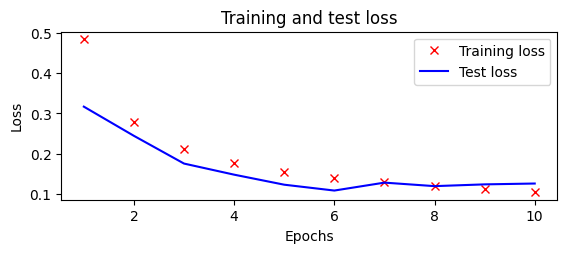

C:\Users\ibrao\AppData\Local\Temp\ipykernel_10712\3532762321.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


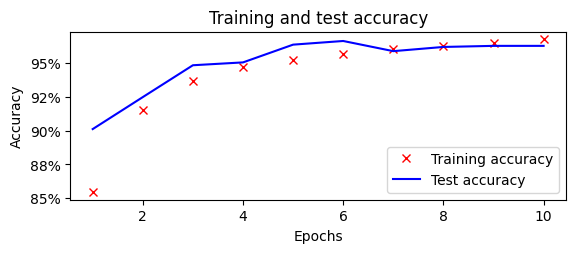

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline 

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'rx', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['accuracy'], 'rx', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.show()

We should note that model accuracy has now fallen to $\pm 97%$, compared to $\pm 98%$ when using the same model for the same number of epochs and batch size, but on a dataset that has a majority of zeros (and not a majority of ones). Additionally, the model achieved an accuracy of $97%$, considerably more slowly than in the scenario where the majority of the input pixels are zero.

The intuition for the decrease in accuracy, when the majority of the data points are non-zero is that, when the majority of pixels are zero, the model's task was easier (less weights had to be fine-tuned), as it had to make predictions based on a few pixel values (the minority that had a pixel value greater than zero). However, a higher number of weights need to be fine-tuned to make predictions when a majority of the data points are non-zero.

## Impact of batch size on model accuracy

In the previous sections, for all the models that we have build, we considered a batch size of $32$. In this section, we will try to understand the impact of varying the batch size on accuracy.

### Getting ready

To understand the reason batch size has an impact on model accuracy, let's contrast 2 scenarios where the total dataset size is $60,000$:
* Batch size is $30,000$
* Batch size is $32$
When **the batch size is large**, the **number of times of weight update per epoch is small**, when compared to the scenario when the batch size is small.
The reason for a high number of weight updates per epoch when the batch size is small is that less data points are considered to calculate the loss value. This results in more batches per epoch, as, loosely, in an epoch, you would have to go through all the training data points in a dataset.

Thus, the lower the batch size, the better the accuracy for the same number of epochs. However, while deciding the number of data points to be considered for a batch size, you should also ensure that the batch size is not too small so that it might overfit on top of a small batch of data.

### How to do it

In the previous recipe, we built a model with a batch size of $32$. In this recipe, we will go ahead and implement the model to contrast the scenario between a low batch size and a high batch size for the same number of epochs:

Epoch 1/100
2/2 [==============================] - 1s 414ms/step - loss: 2.1533 - accuracy: 0.3204 - val_loss: 1.5786 - val_accuracy: 0.7072
Epoch 2/100
2/2 [==============================] - 0s 190ms/step - loss: 1.4519 - accuracy: 0.7247 - val_loss: 1.0625 - val_accuracy: 0.8085
Epoch 3/100
2/2 [==============================] - 0s 193ms/step - loss: 0.9971 - accuracy: 0.8055 - val_loss: 0.7565 - val_accuracy: 0.8412
Epoch 4/100
2/2 [==============================] - 0s 200ms/step - loss: 0.7328 - accuracy: 0.8340 - val_loss: 0.5860 - val_accuracy: 0.8585
Epoch 5/100
2/2 [==============================] - 0s 192ms/step - loss: 0.5821 - accuracy: 0.8502 - val_loss: 0.4875 - val_accuracy: 0.8713
Epoch 6/100
2/2 [==============================] - 0s 187ms/step - loss: 0.4921 - accuracy: 0.8641 - val_loss: 0.4294 - val_accuracy: 0.8826
Epoch 7/100
2/2 [==============================] - 0s 191ms/step - loss: 0.4364 - accuracy: 0.8761 - val_loss: 0.3922 - val_accuracy: 0.8905
Epoch 8/100
2

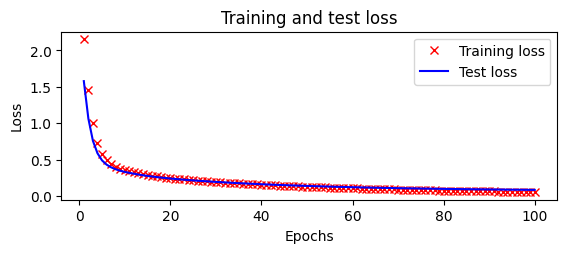

C:\Users\ibrao\AppData\Local\Temp\ipykernel_10712\2457148572.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


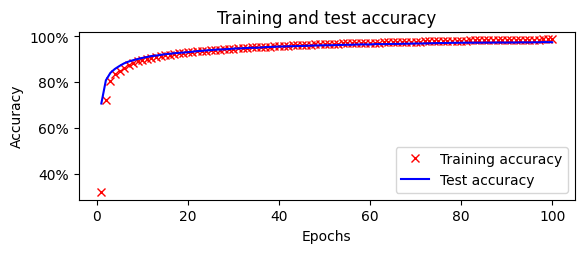

In [21]:
# 1 Preprocess the dataset and fit the model as follows
(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_train = X_train/255
X_test = X_test/255
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
model = Sequential()
model.add(Dense(1000,input_dim=784,activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=30000, verbose=1)

# 2 Plot the training and test accuracy and loss values over different epochs
# (the code to generate the following plots remains the same as the code we
# used in step 8 of the Training a vanilla neural network recipe):
import matplotlib.pyplot as plt
%matplotlib inline 

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'rx', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['accuracy'], 'rx', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.show()

In [22]:
import numpy as np

preds = model.predict(X_test)
correct = 0
for i in range(len(X_test)):
    pred = np.argmax(preds[i],axis=0)
    act = np.argmax(y_test[i],axis=0)
    if(pred==act):
        correct+=1
    else:
        continue

correct/len(X_test)

313/313 [==============================] - 1s 2ms/step


0.9748

### How it works

You should notice that the accuracy is much lower initially and that it catches up only after a considerable number of epochs are run. The reason for a low accuracy during initial epochs is that the number of times of weight update is much lower in this scenario when compared to the previous scenario (where the batch size was smaller).

In this scenario, when the $batch~size$ is $30,000$, and the $total~dataset~size$ is $60,000$, when we run the model for $500$ epochs, the weight updates happens at $epochs \times (\frac{dataset~size}{batch~size}) = 500 \times (\frac{60,000}{30,000}) = 1,000~times$.

In the previous scenario, the weight updates happens at $500 \times (\frac{60,000}{32}) = 937,500~times$.

Hence, **the lower the batch size, the more times the weights get updated and, generally, the better the accuracy is for the same number of epochs**.

At the same time, you should be careful not to have too few examples in the batch size, which might result in not only having a very long training time, but also a potential overfitting scenario.